In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pandas as pd
import numpy as np

### TO DO

- and ensemble 293p
http://forums.fast.ai/t/dog-breed-identification-challenge/7464/293

- Cross Validation (64p 133p) http://forums.fast.ai/t/cross-validation-with-fast-ai/7988?u=sermakarevich

In [5]:
PATH = "data/dogbreed/"
# size of images 224x224
sz = 224

arch = inception_4
# batch size
bs = 58

In [6]:
!ls {PATH}

299_resnext101_64_no_val_submission.csv  labels.csv.zip		test.zip
299_resnext101_64_val_submission.csv	 models			tmp
340_resnext101_64_no_val_submission.csv  sample_submission.csv	train
labels.csv				 test			train.zip


In [7]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1

# Fast AI way of getting train/validation set (80/20): 
val_idxs = [get_cv_idxs(n)]

print("Validation set size is", len(val_idxs[0]))

Validation set size is 2044


### 2 Exploration

In [6]:
label_df = pd.read_csv(label_csv)
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
# Exploring the number of images per breed.
# label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

In [8]:
# Enable data augmentation by using transforms_side_on for image we can flip only horizontally
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# Load data and setting to use test set for prediction/submission to Kaggle
data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)

In [9]:
fn = PATH+data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

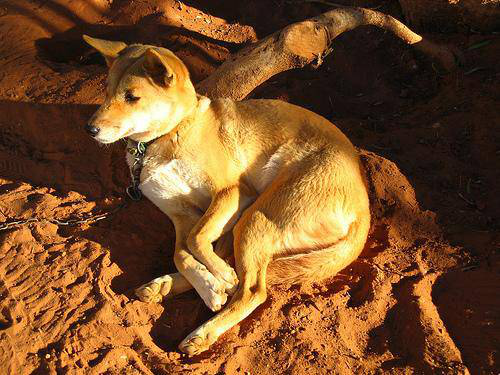

In [10]:
img = PIL.Image.open(fn); img

In [11]:
img.size

(500, 375)

In [12]:
# Create a dictionary mapping size of the file to its name
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [13]:
# Turn dictionary into rows and cols
row_sz, col_sz = list(zip(*size_d.values()))

row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

# row_sz[:5]

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

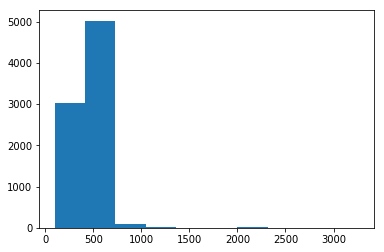

In [14]:
plt.hist(row_sz)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

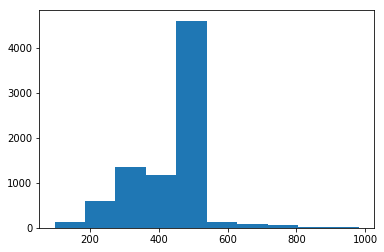

In [15]:
# Grab just images lesser than < 1000px
plt.hist(row_sz[row_sz < 1000])

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

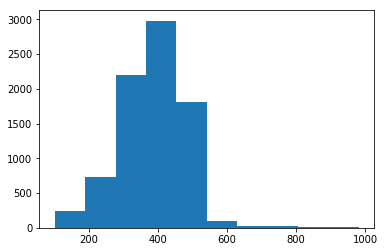

In [16]:
# The same for cols
plt.hist(col_sz[col_sz < 1000])

In [17]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [18]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

### Initial model

In [8]:
# Helps us itterate faster by changing images from small to big
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)
    
    return data if sz>300 else data.resize(340, 'tmp')

In [20]:
# Load our data sets
%time data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))


CPU times: user 380 ms, sys: 24 ms, total: 404 ms
Wall time: 403 ms


In [21]:
# Create our simple model, no data augmentation.
# Precomputing weigths
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [22]:
# Find the best learning rate
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████▍| 133/141 [00:02<00:00, 53.58it/s, loss=10.7]


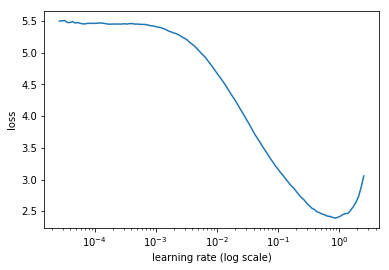

In [23]:
learn.sched.plot()

The plot shows Loss vs. Learning rate for the dataset. 0.01 in our case. Now it is easy to choose an optimal range for learning rate before the curve flattens. Good article explaining this method : https://miguel-data-sc.github.io/2017-11-05-first/

In [24]:
# Training is very fast with precomputed weights
# Set lr to 0.1 as find in lr_find
%time learn.fit(1e-1,5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.827046   0.518925   0.84948   
    1      0.585066   0.545316   0.861864                    
    2      0.422901   0.553773   0.8711                      
    3      0.375514   0.486541   0.871442                    
    4      0.320376   0.507591   0.863437                    

CPU times: user 7.78 s, sys: 8.11 s, total: 15.9 s
Wall time: 11.5 s


[0.5075915, 0.863437338007821]

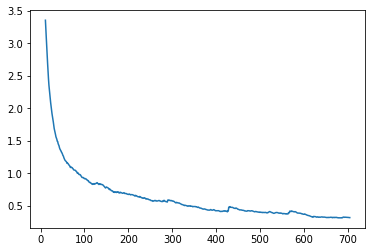

In [25]:
# Plot loss training
learn.sched.plot_loss()

In [26]:
# Usign cycle_len=1 means stochastic gradient descent with restarts used only once during the training.
# Disable precompute and train all conv layers
learn.precompute = False
%time learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.404029   0.432926   0.879721  
    1      0.372293   0.42521    0.884031                    
    2      0.358569   0.419685   0.885468                    
    3      0.35498    0.413958   0.884989                    
    4      0.343694   0.418457   0.883073                    

CPU times: user 8min 45s, sys: 1min 26s, total: 10min 12s
Wall time: 4min 43s


[0.41845667, 0.8830733497937521]

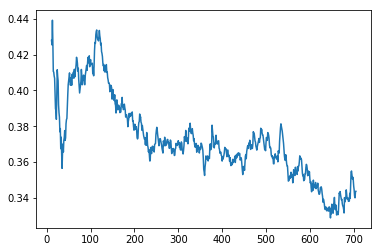

In [27]:
# Plot loss 
learn.sched.plot_loss()

In [28]:
# Save our model in models folder
learn.save('224_inception_4_val')

In [29]:
# Check how we do on validation set
%time log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy_np(probs[0], y), metrics.log_loss(y, probs[0])

CPU times: user 1min 36s, sys: 15.9 s, total: 1min 52s
Wall time: 49.7 s


(0.8820939334637965, 0.42418074619787055)

### Increase the size of images to improve accuracy

In [30]:
# Load our trained model 
learn.load('224_inception_4_val')

# Set image size to 299 and augment images and continue training 
learn.set_data(get_data(299, bs))

# Freeze all but the last layer
learn.freeze()

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [31]:
# Retrain our model only with the last layer 
%time learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.242419   0.249903   0.930556  
    1      0.22367    0.245551   0.930556                    
    2      0.218437   0.244574   0.929598                    

CPU times: user 8min 27s, sys: 1min 37s, total: 10min 5s
Wall time: 5min 23s


[0.24457428, 0.9295977056026459]

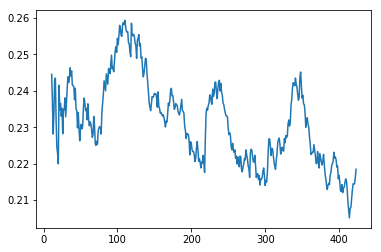

In [32]:
# Plot loss
learn.sched.plot_loss()

In [33]:
# Check our accuracy and log loss on validation set
%time log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy_np(probs[0], y), metrics.log_loss(y, probs[0])

CPU times: user 2min 36s, sys: 29.8 s, total: 3min 6s
Wall time: 1min 34s


(0.928082191780822, 0.24837020518067907)

In [34]:
# Retrain our model with cycle_mult=2 eg SGDR is "multiples of 2" after each epoch. 
# First cycle 1 epochs
# Second cycle 2 epochs
# Third cycle 4 epochs 
# etc...
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.226333   0.244402   0.929598  
    1      0.213775   0.242939   0.933429                    
    2      0.218365   0.241802   0.932471                    
    3      0.220849   0.242093   0.929598                    
    4      0.216345   0.244358   0.928161                    
    5      0.191498   0.243791   0.927203                    
    6      0.19357    0.243115   0.929119                    

CPU times: user 19min 46s, sys: 3min 46s, total: 23min 32s
Wall time: 12min 35s


[0.24311545, 0.9291187773148218]

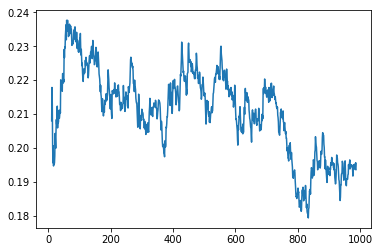

In [35]:
# Plot loss
learn.sched.plot_loss()

In [36]:
# Find the best learning rate for actual model
# %time learn.lr_find()
# learn.sched.plot()

In [37]:
# Retrain again our model to see if training can still improve the model 
# Change lr to 0.001, our layers are freezed
# %time learn.fit(1e-3, 1, cycle_len=2)

# [0.25735068, 0.9224137994978163] freezed layers

# Plot loss 
# learn.sched.plot_loss()

In [38]:
learn.save('299_inception_4_val')

In [39]:
# Check our accuracy and log loss on validation set
%time log_preds, y = learn.TTA()
probs = np.exp(log_preds)
accuracy_np(probs[0], y), metrics.log_loss(y, probs[0])

CPU times: user 2min 37s, sys: 28.8 s, total: 3min 6s
Wall time: 1min 34s


(0.9275929549902152, 0.24708361718160493)

##### Retrain our model on all training data (no validation), images 360x360,  UNFREEZING all layers.

In [9]:
# Set only one image for validation set  
# Our stats: trn_loss, val_loss and accuracy will be wrong, use it only with already defined model
val_idxs = [0]

# Get data without validation set and images 340x340 and bs 18
bs = 18

In [10]:
# Enable data augmentation by using transforms_side_on for image we can flip only horizontally
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# Load data and setting to use test set for prediction/submission to Kaggle
data = ImageClassifierData.from_csv(PATH, 
                                    'train', 
                                    f'{PATH}labels.csv', 
                                    test_name='test',
                                    val_idxs=val_idxs, # Create train/validation set
                                    suffix='.jpg',
                                    tfms=tfms,
                                    bs=bs)

# Set precompute=Flse activations were previously generated based on our validation set and training set split
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('299_inception_4_val')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.280042   0.000126   1.0       
    1      0.246096   0.000144   1.0                         

CPU times: user 8min 16s, sys: 56.9 s, total: 9min 13s
Wall time: 4min 47s


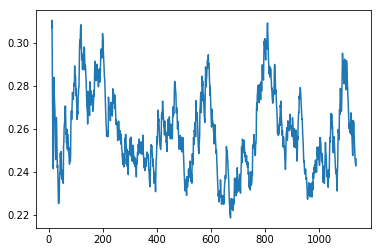

In [13]:
learn.set_data(get_data(360, bs))

# Learn on the last layer first
%time learn.fit(1e-2, 2, cycle_len=1)

# Plot loss
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.225425   0.000109   1.0       
    1      0.208027   8.4e-05    1.0                         
    2      0.230591   4.6e-05    1.0                         

CPU times: user 12min 21s, sys: 1min 27s, total: 13min 48s
Wall time: 7min 11s


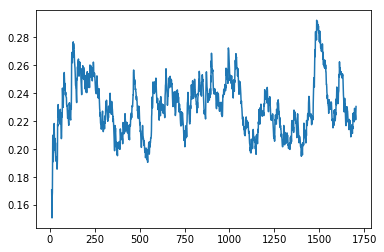

In [14]:
# Start training
%time learn.fit(1e-3, 2, cycle_len=1, cycle_mult=2)
learn.save('360_inception_4_no_val')

# Plot loss
learn.sched.plot_loss()

### Retrain our model on all training data (no validation), images 400x400,  UNFREEZING all layers.

In [11]:
# Set precompute=Flse activations were previously generated based on our validation set and training set split
# learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('360_inception_4_no_val')


# Get data without validation set and images 400x400 and bs 58
learn.set_data(get_data(400, bs))

# Learn on the last layer first
# %time learn.fit(1e-1, 2, cycle_len=1)

# Plot loss
# learn.sched.plot_loss()

In [ ]:
# Train on all layers
#learn.unfreeze()

# Find the best learning rate for actual model
#%time learn.lr_find()
#learn.sched.plot()

In [12]:
# Start training with lr=0.1, looking at our lr plot there is no difference betwen lr rates
%time learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.234878   9.7e-05    1.0       
    1      0.208803   9.9e-05    1.0                         
    2      0.272955   0.000105   1.0                         
    3      0.209558   6.1e-05    1.0                         
    4      0.242017   9.5e-05    1.0                         
    5      0.251145   7.8e-05    1.0                         
    6      0.238853   0.000143   1.0                         

CPU times: user 35min 33s, sys: 6min 28s, total: 42min 2s
Wall time: 22min 51s


[0.00014305115, 1.0]

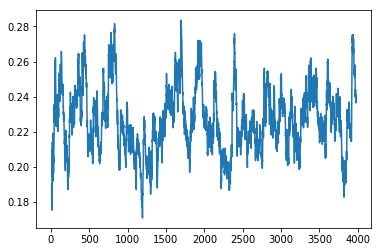

In [13]:
# Plot loss
learn.sched.plot_loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

 61%|██████    | 346/568 [06:02<03:52,  1.05s/it, loss=0.596]

KeyboardInterrupt: 

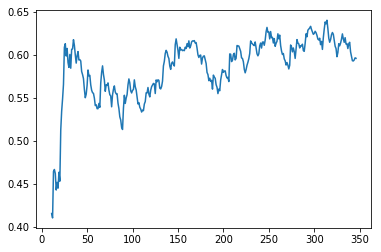

In [14]:
learn.unfreeze()
%time learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [ ]:
learn.save('400_inception_4_no_val')

### Make our prediction file using all training images 400 x 400 

In [ ]:
# Set precompute=Flse activations were previously generated based on our validation set and training set split
# learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.load('400_inception_4_no_val')

%time log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

In [ ]:
# Convert to probs
preds = np.exp(log_preds_test)

df = pd.DataFrame(preds)
df.columns = data.classes

df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])
df.head()

In [ ]:
# compression="gzip"
df.to_csv(f'{PATH}400_inception_4_no_val_submission.csv', index=False)

In [ ]:
FilleLink(f'{PATH}400_inception_4_no_val_submission.csv')